## Traditional Sentence Similarity
There are traditional similarity measurements that will be evaluated here using SICK and STS data. 


### Loading Data
#### STS Benchmark
The STS Benchmark brings together the English data from the SemEval sentence similarity tasks between 2012 and 2017. The data is split in training, development and test data: http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark

In [1]:
from preprocessing.load_data import download_and_load_sts_data, download_and_load_sick_dataset

sts_dev, sts_test = download_and_load_sts_data()
sts_test[:10]

/home/tharindu/anaconda3/envs/sentence_similarity_3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/tharindu/anaconda3/envs/sentence_similarity_3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/tharindu/anaconda3/envs/sentence_similarity_3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

,sent_1,sent_2,sim
0,A girl is styling her hair.,A girl is brushing her hair.,2.500
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.600
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.000
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.200
4,A man is playing a harp.,A man is playing a keyboard.,1.500
5,A woman is cutting onions.,A woman is cutting tofu.,1.800
6,A man is riding an electric bicycle.,A man is riding a bicycle.,3.500
7,A man is playing the drums.,A man is playing the guitar.,2.200
8,A man is playing guitar.,A lady is playing the guitar.,2.200
9,A man is playing a guitar.,A man is playing a trumpet.,1.714


#### SICK data
The SICK dataset contains 10,000 English sentence pairs labelled with their semantic relatedness and entailment relation.

In [2]:
sick_all, sick_train, sick_test, sick_dev = download_and_load_sick_dataset()
sick_all[:10]

,idx,sent_1,sent_2,sim,label
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,NEUTRAL
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,NEUTRAL
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,ENTAILMENT
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,NEUTRAL
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,NEUTRAL
5,12,Two dogs are fighting,Two dogs are wrestling and hugging,4.0,NEUTRAL
6,14,A brown dog is attacking another animal in fro...,Two dogs are fighting,3.5,NEUTRAL
7,18,A brown dog is attacking another animal in fro...,Two dogs are wrestling and hugging,3.2,NEUTRAL
8,25,Nobody is riding the bicycle on one wheel,A person in a black jacket is doing tricks on ...,2.8,NEUTRAL
9,26,A person is riding the bicycle on one wheel,A man in a black jacket is doing tricks on a m...,3.7,NEUTRAL


### Percent Match

Perecent Match focusses on the common words in two sentences. We have created two benchmarks to evaluate it. 

1. Considering the intersection of the words in the two strings
2. Considering the intersection of the words in the two string after removing stop words. 



In [3]:
import functools as ft

from matrices.traditional.percent_match import percent_match_benchmark

benchmarks = [("PM", ft.partial(percent_match_benchmark, use_stoplist=False)),
              ("PM-STOP", ft.partial(percent_match_benchmark, use_stoplist=True))]


In [4]:
import scipy
import matplotlib.pyplot as plt
from preprocessing.normalize import normalize
from utility.run_experiment import run_experiment
import pandas as pd

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
row = 0
column = 0
sick_train = normalize(sick_train, ["sim"])
for i in range(0, 2):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = normalize(sick_train, ["predicted_sim"])
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    if(i < 2):
        column = i
        
    sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(1500, 0.05, textstr, fontsize=12)

Taking percent match after removing the stop words benchmark seems to perform well for SICK dataset. Let's evaluate the sentences it got completely wrong. 

In [5]:
import math
import numpy as np

sims, topic = run_experiment(sick_train, benchmarks[1])
sick_train['predicted_sim'] = pd.Series(sims).values

sick_train["diff"] = np.sqrt((sick_train["predicted_sim"] - sick_train["sim"])**2)

sick_train = sick_train.sort_values("diff", ascending=False)
sick_train[:10]                                    

,idx,sent_1,sent_2,sim,label,predicted_sim,id,diff
1124,2543,Someone is cutting a tomato,The person is slicing a vegetable,0.900,ENTAILMENT,0.0,3883,0.900
2455,5466,A guy is mowing the lawn,Grass is being mowed by a man,0.875,ENTAILMENT,0.0,3713,0.875
1759,3976,A girl is awakening,A child is waking up,0.850,ENTAILMENT,0.0,3563,0.850
3357,7462,A rider is surfing the wave,A man is performing a trick on a surfboard in ...,0.850,NEUTRAL,0.0,3487,0.850
803,1825,The person is dicing up a pepper which is orange,A cook is slicing some bell peppers,0.825,NEUTRAL,0.0,3353,0.825
3517,7790,A snowboarder is jumping through the air,A person wearing grey pants is airborne on a s...,0.800,NEUTRAL,0.0,3193,0.800
801,1822,A cook is slicing some bell peppers,An orange pepper is being diced up by a person,0.775,NEUTRAL,0.0,3019,0.775
1812,4094,A picture is being drawn by a man,The person is drawing,0.775,ENTAILMENT,0.0,3090,0.775
4060,9030,A brown dog is running after a black dog on a ...,Two dogs are playing on a beach,0.775,NEUTRAL,0.0,3047,0.775
1494,3400,Nobody is beating an egg,The woman is stirring eggs in a bowl,0.775,CONTRADICTION,0.0,3110,0.775


The method obviously fails to identify relationship between words such as tomato and vegetable etc. 

Let's evaluate it with STS Data set also

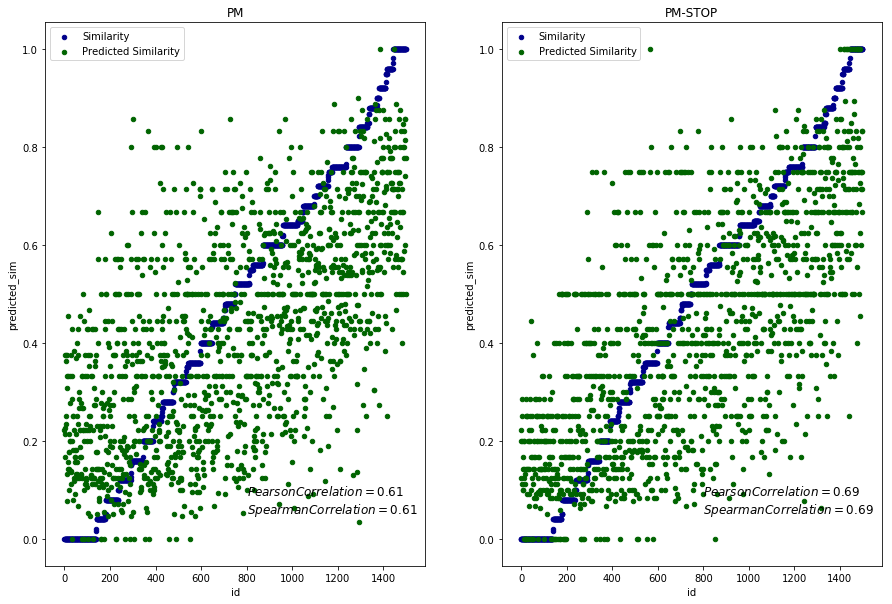

In [6]:
import scipy


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
row = 0
column = 0
sts_dev = normalize(sts_dev, ["sim"])
for i in range(0, 2):
    sims, topic = run_experiment(sts_dev, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sts_dev['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sts_dev['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sts_dev['predicted_sim'] = pd.Series(sims).values
    sts_dev = normalize(sts_dev, ["predicted_sim"])
    sts_dev = sts_dev.sort_values('sim')
    id = list(range(0, len(sts_dev.index)))
    sts_dev['id'] = pd.Series(id).values
    
    if(i < 2):
        column = i
        
    sts_dev.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, ax=axes[column]);
    sts_dev.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=axes[column]);
    axes[column].text(800, 0.05, textstr, fontsize=12)

Again the stop word removing bench mark performed well. Taking in to account the sentences it predicted completely wrong. 

In [7]:
import math
import numpy as np

sims, topic = run_experiment(sts_dev, benchmarks[1])
sts_dev['predicted_sim'] = pd.Series(sims).values

sts_dev["diff"] = np.sqrt((sts_dev["predicted_sim"] - sts_dev["sim"])**2)

sts_dev = sts_dev.sort_values("diff", ascending=False)
sts_dev[:10]   

,sent_1,sent_2,sim,predicted_sim,id,diff
794,It would be unusual for a snake to attack a st...,"I'm no herpetologist, but in my experience, sn...",0.84,0.062500,1315,0.777500
984,"Yes, this is OK, as it allows you to emphasise...",I believe this is perfectly acceptable and doe...,0.80,0.076923,1243,0.723077
1283,Eurozone backs Greek bailout,Eurozone agrees Greece bail-out,0.96,0.250000,1440,0.710000
507,A man is carrying a canoe with a dog.,A dog is carrying a man in a canoe.,0.36,1.000000,566,0.640000
644,It indeed appears the Andromeda galaxy (M31) a...,"In a few billion years, the Milky Way and Andr...",0.88,0.250000,1342,0.630000
137,A woman is putting on sun glasses.,A woman puts on sunglasses.,1.00,0.400000,1473,0.600000
750,This looks a lot like an invitation to a No Tr...,"I concur with @T.E.D; the question is a ""no Tr...",0.76,0.166667,1229,0.593333
1344,UK alert on Syrian chemical arms,West raises stakes over Syria chemical claims,0.76,0.166667,1181,0.593333
942,Yes a team can use the same player for both bo...,There's no rule that decides which players can...,0.84,0.250000,1304,0.590000
492,A skateboarder jumps off the stairs.,A dog jumps off the stairs.,0.16,0.750000,331,0.590000


It has failed to identify the relationships between the words like sunglasses and sun glasses. Also it doesn't take the word order in to account

### Levenshtein Distance
The Levenshtein distance (or edit distance) between two strings is the minimal number of insertions, deletions, and substitutions of one character for another that will transform one string into the other. It is often used as a similarity measure. 

In [8]:
import functools as ft
from matrices.traditional.levenshtein_distance import run_levenshtein_benchmark

benchmarks = [("LEVENSHTEIN", ft.partial(run_levenshtein_benchmark))]

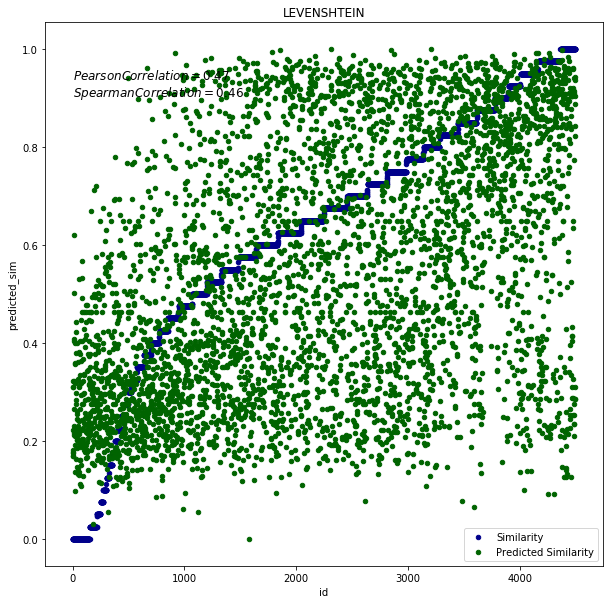

In [9]:
import scipy
import matplotlib.pyplot as plt
from preprocessing.normalize import normalize
import pandas as pd
from utility.run_experiment import run_experiment

sick_train = normalize(sick_train, ["sim"])
for i in range(0, 1):
    sims, topic = run_experiment(sick_train, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sick_train['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sick_train['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sick_train['predicted_sim'] = pd.Series(sims).values
    sick_train = normalize(sick_train, ["predicted_sim"])
    sick_train = sick_train.sort_values('sim')
    id = list(range(0, len(sick_train.index)))
    sick_train['id'] = pd.Series(id).values
    
    
    ax = sick_train.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, figsize=(10,10));
    sick_train.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=ax);
    ax.text(0, 0.9, textstr, fontsize=12)



The correlation between predicted value and the actual similarity is quite low. But let's check the sentences it got completely wrong

In [10]:
import math
import numpy as np

sims, topic = run_experiment(sick_train, benchmarks[0])
sick_train['predicted_sim'] = pd.Series(sims).values
sick_train = normalize(sick_train, ["predicted_sim"])
sick_train["diff"] = np.sqrt((sick_train["predicted_sim"] - sick_train["sim"])**2)

sick_train = sick_train.sort_values("diff", ascending=False)
sick_train[:10]                                    

,idx,sent_1,sent_2,sim,label,predicted_sim,id,diff
1877,4239,A man is playing an electronic keyboard,An electronic keyboard is being played by a man,0.975,ENTAILMENT,0.092036,4309,0.882964
2155,4853,A man is playing an electronic keyboard,An electronic keyboard is being played by a man,0.975,ENTAILMENT,0.092036,4254,0.882964
2443,5446,A woman is frying fish,Fish is being fried by a woman,1.000,ENTAILMENT,0.125478,4458,0.874522
1983,4472,The content of a bowl is being mixed by a man,A man is mixing the content of a bowl,1.000,ENTAILMENT,0.125478,4394,0.874522
3197,7082,The crowd is watching a football game,A football game is being watched by the crowd,1.000,ENTAILMENT,0.125478,4416,0.874522
3183,7035,The motocross rider is wearing blue and black ...,Blue and black pants are being worn by the mot...,1.000,ENTAILMENT,0.133221,4428,0.866779
3824,8489,A man with no shirt is holding a football,A football is being held by a man with no shirt,1.000,ENTAILMENT,0.139810,4413,0.860190
3553,7878,Three people are driving ATVs,ATVs are being driven by three people,1.000,ENTAILMENT,0.143684,4415,0.856316
3287,7304,The man in the straw hat is smoking a cigarette,A cigarette is being smoked by the man in the ...,1.000,ENTAILMENT,0.145891,4378,0.854109
1541,3508,A woman is chopping up garlic,Garlic is being diced by the woman,0.950,ENTAILMENT,0.099062,4038,0.850938


The results show that this fails to capture the passive voices of the sentences even when the meaning is same. Let's check the matrix with STS Data too. 

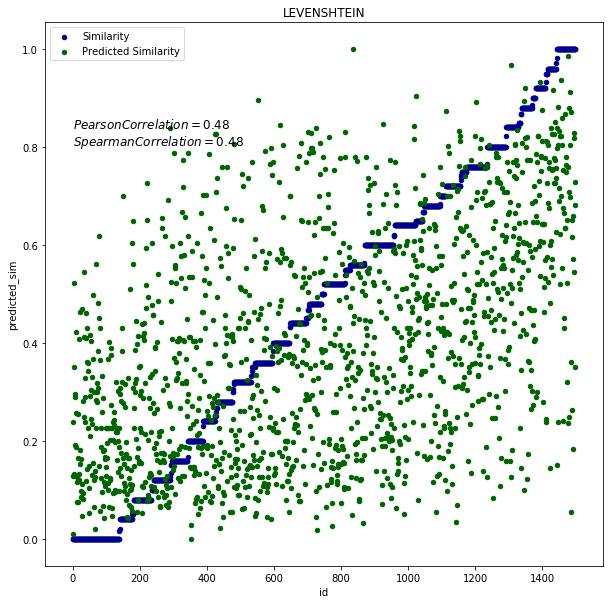

In [11]:
import scipy
import matplotlib.pyplot as plt
from preprocessing.normalize import normalize
import pandas as pd
from utility.run_experiment import run_experiment

sts_dev = normalize(sts_dev, ["sim"])
for i in range(0, 1):
    sims, topic = run_experiment(sts_dev, benchmarks[i])
    pearson_correlation = scipy.stats.pearsonr(sims, sts_dev['sim'])[0]
    spearman_correlation = scipy.stats.spearmanr(sims, sts_dev['sim'])[0]
    textstr = '$Pearson Correlation=%.2f$\n$Spearman Correlation=%.2f$'%(pearson_correlation, spearman_correlation)
    sts_dev['predicted_sim'] = pd.Series(sims).values
    sts_dev = normalize(sts_dev, ["predicted_sim"])
    sts_dev = sts_dev.sort_values('sim')
    id = list(range(0, len(sts_dev.index)))
    sts_dev['id'] = pd.Series(id).values
    
    
    ax = sts_dev.plot(kind='scatter', x='id', y='sim',color='DarkBlue', label='Similarity', title = topic, figsize=(10,10));
    sts_dev.plot(kind='scatter', x='id', y='predicted_sim', color='DarkGreen', label='Predicted Similarity', ax=ax);
    ax.text(0, 0.8, textstr, fontsize=12)


THe correlations are similar to the porevious dataset. However let's evaluate the sentences it got completely wrong. 

In [12]:
import math
import numpy as np

sims, topic = run_experiment(sts_dev, benchmarks[0])
sts_dev['predicted_sim'] = pd.Series(sims).values
sts_dev = normalize(sts_dev, ["predicted_sim"])
sts_dev["diff"] = np.sqrt((sts_dev["predicted_sim"] - sts_dev["sim"])**2)

sts_dev = sts_dev.sort_values("diff", ascending=False)
sts_dev[:10]   

,sent_1,sent_2,sim,predicted_sim,id,diff
1181,"Gainer said the two staff aides are ""very sorr...",The security personnel performed ``well within...,1.00,0.055555,1485,0.944445
1099,EU ministers were invited to the conference bu...,"Gerry Kiely, a EU agriculture representative i...",1.00,0.151277,1444,0.848723
84,The man used a sword to slice a plastic bottle.,A man sliced a plastic bottle with a sword.,1.00,0.182678,1491,0.817322
1102,"But in the end, all the worm did was visit a p...","But Vincent Weafer, security director with Sym...",0.96,0.144476,1423,0.815524
1245,"A Merrill Lynch spokesman said ""we are pleased...","""We are very pleased with the judge's decision...",0.88,0.099258,1346,0.780742
238,A man plays the guitar and sings.,A man is singing and playing a guitar.,1.00,0.236827,1476,0.763173
525,A boy is at school taking a test.,The boy is taking a test at school.,1.00,0.237748,1446,0.762252
1092,BioReliance's stock closed down 2 cents yester...,Shares of BioReliance sold at $47.98 at the cl...,1.00,0.240662,1462,0.759338
1034,"Another million barrels, bought by Spanish ref...","A Spanish tanker, Sandra Tapias, was to be loa...",0.88,0.121772,1354,0.758228
1123,"The last time the survey was conducted, in 199...","In 1995, the last survey, those numbers were e...",1.00,0.249078,1479,0.750922


### Conclusions

Percent match after removing stop words performed better than Levenshtein distance for these 2 datasets. But it can't come close to the word embedding based similarity approaches. 
